In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import transforms
from astropy.io import fits 
from skimage.transform import resize
import time

import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
from matplotlib import pyplot as plt

from weighting import weighting

torch.cuda.benchmark=True

In [2]:
class CategoricalNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            
            torch.nn.Conv2d(1,64,5,padding=2), # 1 input, 32 out, filter size = 5x5, 2 block outer padding
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128,256,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2))
 
        self.classifier = torch.nn.Sequential(
		    torch.nn.Dropout(0.25),
            torch.nn.Linear(256*16*16,256), # Fully connected layer 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(256,10))
        
    def forward(self,x):
        features = self.feature_extractor(x)
        output = self.classifier(features.view(int(x.size()[0]),-1))
        output= torch.nn.functional.log_softmax(output,dim=1)
        return output

In [3]:
class RegressionNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 256, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(512, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(256, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.25),
            torch.nn.Linear(128 * 2 * 2, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(256, 10))

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features.view(int(x.size()[0]), -1))
        # output= F.log_softmax(output,dim=1) # Give results using softmax
        return output

In [4]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

In [5]:
import torch.utils.data as data

IMG_EXTENSIONS = [
    ".fits"
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images


def default_fits_loader(file_name: str, img_size: tuple, slice_index):
    file = fits.open(file_name)
    _data = file[1].data
    _data = resize(_data[slice_index], img_size)
    _label = file[0].header['LABEL']

    if len(_data.shape) < 3:
        _data = _data.reshape((*_data.shape, 1))
    
    return _data, _label


class FITSCubeDataset(data.Dataset):
    def __init__(self, data_path, cube_length, transforms, img_size):
        self.data_path = data_path
        self.transforms = transforms
        self.img_size = img_size
        self.cube_length = cube_length
        self.img_files = make_dataset(data_path)

    def __getitem__(self, index):
        cube_index = index // self.cube_length
        slice_index = index % self.cube_length
        _img, _label = default_fits_loader(self.img_files[cube_index], self.img_size, slice_index)
        _img[_img != _img] = 0
        if self.transforms is not None:
            _data = (self.transforms(_img), _label)
        else:
            _data = (_img, _label)
            
        return _data

    def __len__(self):
        return len(self.img_files)*self.cube_length

In [6]:
IMG_PATH = "E:/Documents/Python_Scripts/CNN/TRAINING/"

def plot_accuracy(accuracies, val_acc, epochs, filename):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(0, max(epochs))
    ax.set_ylim(0, 100)
    plt.plot(epochs, accuracies,'b',label='Training Accuracy',zorder=1)
    plt.plot(epochs, val_acc,'purple',label='Validation Accuracy',zorder=0)
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(loc='best',fontsize='small')
    fig.savefig(IMG_PATH+filename, bbox_inches='tight')
    plt.close()

In [7]:
def adjust_learning_rate(optimizer, epoch, initial_lr, num_epochs):
    decay = initial_lr / num_epochs
    lr = initial_lr - decay*epoch
    print("Set LR to %f" % lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
def train(model: torch.nn.Module, 
          transforms, 
          data_path="E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/", 
          val_path="E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/",  
          num_epochs=50, 
          batch_size=32, 
          verbose=True,
          cube_length=640, img_size=(64, 64), 
          loss=torch.nn.CrossEntropyLoss(), 
          lr_schedule=True, initial_lr=1e-3, suffix=""):

    data_path = os.path.abspath(data_path)
    val_path = os.path.abspath(val_path)
	
    model = model.train()
    device = torch.device("cuda")
    model = model.to(device).to(torch.float)
    start = time.time()
    
    print('Creating sampling weight array')
    train_loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size=batch_size, shuffle=False)
    dataiter = iter(train_loader)
    dummy_labels = []
    for idx, (batch, target) in enumerate(tqdm(train_loader)):
        dummy_labels.append(np.array(target.numpy()))
    dummy_labels = np.hstack(dummy_labels)
    print(len(dummy_labels))
    weights = weighting(dummy_labels)
    sampler = WeightedRandomSampler(weights, len(weights))
    end = time.time()
    print('Weights Created in %.2gs'%(end-start))
    #batch size was 10*640?
    start = time.time()
    val_loader = DataLoader(FITSCubeDataset(val_path, cube_length, transforms, img_size), batch_size=batch_size, shuffle=False)
    dataiter = iter(val_loader)
    dummy_val_labels = []
    for idx, (batch, target) in enumerate(tqdm(val_loader)):
        dummy_val_labels.append(np.array(target.numpy()))
    dummy_val_labels = np.hstack(dummy_val_labels)
    print(len(dummy_val_labels))
    val_weights = weighting(dummy_val_labels)
    val_sampler = WeightedRandomSampler(val_weights, len(val_weights))
    end = time.time()
    print('Validation weights Created in %.2gs'%(end-start))
    
    loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size, shuffle=False, sampler=sampler)
    validation_loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size, shuffle=False, sampler=val_sampler)    
    optim = torch.optim.Adam(model.parameters(), initial_lr)
	
    accuracies, val_accuracies, epochs = [0], [0], [0]
	
    for i in range(num_epochs):
        print("Epoch %d of %d" % (i+1, num_epochs))
        _accuracies = []
        _val_accuracies = []
        model.train(True)
        for idx, (batch, target) in enumerate(tqdm(loader)):
            batch = batch.to(device).to(torch.float)
            if isinstance(loss, torch.nn.CrossEntropyLoss):
                target = target.to(device).to(torch.long)
            else:
                target = target.to(device).to(torch.float)
            pred = model(batch)

            loss_value = loss(pred, target)

            optim.zero_grad()
            loss_value.backward()
            optim.step()

            pred_npy = pred.detach().cpu().numpy()
            target_npy = target.detach().cpu().numpy()

            if isinstance(loss, torch.nn.CrossEntropyLoss):
                pred_npy = np.argmax(pred_npy, axis=1) 
                
            ###Change the error metric here###

            pred_int = np.round(pred_npy).astype(np.uint8).reshape(-1)
            target_npy = target_npy.astype(np.uint8).reshape(-1)

            _accuracies.append(accuracy_score(target_npy, pred_int)*100)
            
        epochs.append(i+1)

        mean_accuracy = sum(_accuracies)/len(_accuracies)
        accuracies.append(mean_accuracy)

        print("Mean accuracy: %f" % mean_accuracy)
        
        model.train(False)

        for idx, (batch, target) in enumerate(tqdm(validation_loader)):
            batch = batch.to(device).to(torch.float)
            if isinstance(loss, torch.nn.CrossEntropyLoss):
                target = target.to(device).to(torch.long)
            else:
                target = target.to(device).to(torch.float)
            pred = model(batch)

            loss_value = loss(pred, target)

            pred_npy = pred.detach().cpu().numpy()
            target_npy = target.detach().cpu().numpy()

            if isinstance(loss, torch.nn.CrossEntropyLoss):
                pred_npy = np.argmax(pred_npy, axis=1) 
                
            ###Change the error metric here###

            pred_int = np.round(pred_npy).astype(np.uint8).reshape(-1)
            target_npy = target_npy.astype(np.uint8).reshape(-1)

            _val_accuracies.append(accuracy_score(target_npy, pred_int)*100)

        mean_accuracy = sum(_val_accuracies)/len(_val_accuracies)
        val_accuracies.append(mean_accuracy)
        if lr_schedule:
            plot_accuracy(accuracies,val_accuracies, epochs, "Validation_accuracy_scheduler%s.png" % suffix)
        else:
            plot_accuracy(accuracies,val_accuracies, epochs, "Validation_accuracy_no_scheduler%s.png" % suffix)
        print("Mean Validation accuracy: %f" % mean_accuracy)
    
        
        
        model.eval()


In [9]:
if __name__ == '__main__':
    print("Creating Model and Initializing weights")
	
#    for model_class, loss_fn, suffix in zip([CategoricalNet, RegressionNet], [torch.nn.CrossEntropyLoss(), torch.nn.MSELoss()], ["_categorical", "_regression"]):
#        for schedule in [True, False]:
            
    model_class, loss_fn, suffix = CategoricalNet, torch.nn.CrossEntropyLoss(), "_categorical"
    schedule = True
    
    model = model_class()
    model.apply(weight_init)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0], [1])])

start = time.time()
train(model, transform, num_epochs=80, batch_size=64, lr_schedule=schedule, loss=loss_fn, suffix=suffix)
end = time.time()
print('TRAIN TIME:')
print('%.2gs'%(end-start))

Creating Model and Initializing weights
Creating sampling weight array


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


6400
Weights Created in 24s


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


6400
Validation weights Created in 20s
Epoch 1 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


Mean accuracy: 28.562500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Mean Validation accuracy: 43.187500
Epoch 2 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


Mean accuracy: 42.875000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Mean Validation accuracy: 61.906250
Epoch 3 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


Mean accuracy: 51.421875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


Mean Validation accuracy: 70.781250
Epoch 4 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


Mean accuracy: 62.234375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Mean Validation accuracy: 67.796875
Epoch 5 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Mean accuracy: 67.140625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


Mean Validation accuracy: 79.546875
Epoch 6 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]


Mean accuracy: 72.093750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Mean Validation accuracy: 83.078125
Epoch 7 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 77.031250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 89.765625
Epoch 8 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Mean accuracy: 77.421875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


Mean Validation accuracy: 84.750000
Epoch 9 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


Mean accuracy: 80.765625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Mean Validation accuracy: 92.265625
Epoch 10 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 83.718750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 95.281250
Epoch 11 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Mean accuracy: 84.625000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Mean Validation accuracy: 94.953125
Epoch 12 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 86.781250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 96.125000
Epoch 13 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 88.281250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


Mean Validation accuracy: 95.687500
Epoch 14 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


Mean accuracy: 87.843750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]


Mean Validation accuracy: 93.140625
Epoch 15 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Mean accuracy: 89.687500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


Mean Validation accuracy: 95.859375
Epoch 16 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Mean accuracy: 90.812500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 97.718750
Epoch 17 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 91.046875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 97.937500
Epoch 18 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 91.281250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 97.734375
Epoch 19 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 91.953125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 97.406250
Epoch 20 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.63it/s]


Mean accuracy: 92.203125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 98.734375
Epoch 21 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 92.703125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 98.046875
Epoch 22 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 93.093750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 97.828125
Epoch 23 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 92.937500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 96.515625
Epoch 24 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 93.031250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 97.968750
Epoch 25 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 94.375000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Mean Validation accuracy: 98.109375
Epoch 26 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


Mean accuracy: 94.062500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 98.375000
Epoch 27 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 94.578125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


Mean Validation accuracy: 98.281250
Epoch 28 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


Mean accuracy: 92.734375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


Mean Validation accuracy: 95.687500
Epoch 29 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Mean accuracy: 93.468750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Mean Validation accuracy: 98.140625
Epoch 30 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


Mean accuracy: 94.812500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Mean Validation accuracy: 98.203125
Epoch 31 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


Mean accuracy: 95.218750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


Mean Validation accuracy: 98.890625
Epoch 32 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


Mean accuracy: 95.687500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


Mean Validation accuracy: 99.046875
Epoch 33 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Mean accuracy: 95.953125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


Mean Validation accuracy: 99.046875
Epoch 34 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]


Mean accuracy: 96.281250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]


Mean Validation accuracy: 99.171875
Epoch 35 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 95.531250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


Mean Validation accuracy: 99.156250
Epoch 36 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 95.078125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


Mean Validation accuracy: 98.875000
Epoch 37 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


Mean accuracy: 95.765625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Mean Validation accuracy: 99.546875
Epoch 38 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


Mean accuracy: 96.109375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


Mean Validation accuracy: 98.468750
Epoch 39 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 96.343750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Mean Validation accuracy: 99.328125
Epoch 40 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 96.640625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.093750
Epoch 41 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 96.906250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Mean Validation accuracy: 98.609375
Epoch 42 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 96.375000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


Mean Validation accuracy: 99.546875
Epoch 43 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 97.234375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.187500
Epoch 44 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 95.859375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.375000
Epoch 45 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 96.500000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.578125
Epoch 46 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 97.265625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Mean Validation accuracy: 99.812500
Epoch 47 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 96.875000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.593750
Epoch 48 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 96.796875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Mean Validation accuracy: 99.250000
Epoch 49 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.921875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.656250
Epoch 50 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]


Mean accuracy: 97.718750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.593750
Epoch 51 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 96.703125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.718750
Epoch 52 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.500000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.562500
Epoch 53 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 97.484375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.734375
Epoch 54 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 97.796875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.859375
Epoch 55 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.234375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.750000
Epoch 56 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 98.203125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


Mean Validation accuracy: 99.734375
Epoch 57 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.59it/s]


Mean accuracy: 97.687500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Mean Validation accuracy: 99.375000
Epoch 58 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.000000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 98.343750
Epoch 59 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.843750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.921875
Epoch 60 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.015625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Mean Validation accuracy: 99.828125
Epoch 61 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.953125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.421875
Epoch 62 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 97.484375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.515625
Epoch 63 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.812500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.406250
Epoch 64 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Mean accuracy: 97.828125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.656250
Epoch 65 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.187500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.984375
Epoch 66 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.875000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.796875
Epoch 67 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.359375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.531250
Epoch 68 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 97.671875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.828125
Epoch 69 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.828125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.921875
Epoch 70 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 98.234375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.953125
Epoch 71 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 97.890625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.718750
Epoch 72 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 98.078125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Mean Validation accuracy: 99.546875
Epoch 73 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 97.562500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 100.000000
Epoch 74 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.218750


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.890625
Epoch 75 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Mean accuracy: 98.703125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Mean Validation accuracy: 99.937500
Epoch 76 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.437500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.890625
Epoch 77 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.640625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.703125
Epoch 78 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 98.578125


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


Mean Validation accuracy: 99.968750
Epoch 79 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Mean accuracy: 98.625000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


Mean Validation accuracy: 99.921875
Epoch 80 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


Mean accuracy: 98.281250


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Mean Validation accuracy: 99.828125
TRAIN TIME:
5.1e+03s


In [10]:
torch.save(model, IMG_PATH+'CategoricalNet.pt')

C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CategoricalNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
tester = torch.load(IMG_PATH+'CategoricalNet.pt')


In [12]:
tester

CategoricalNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.25)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [13]:
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        print(m.weight.data)

tensor([[[[ 0.0999,  0.0910,  0.0701,  0.0778,  0.1133],
          [ 0.0292,  0.0244, -0.0005, -0.0142,  0.0637],
          [ 0.0499,  0.0609,  0.0390,  0.0610,  0.0520],
          [ 0.0361,  0.0237, -0.0415,  0.0098,  0.0995],
          [ 0.0612,  0.0445,  0.1240,  0.0828,  0.0478]]],


        [[[-0.0146, -0.0799, -0.1182, -0.0418, -0.0117],
          [-0.0783, -0.0643, -0.0982, -0.0935, -0.0589],
          [ 0.0236,  0.1319,  0.1693,  0.0423, -0.0762],
          [ 0.0220,  0.1007,  0.2266,  0.2028,  0.0663],
          [-0.0245,  0.0580,  0.1015,  0.0746,  0.0167]]],


        [[[ 0.1405,  0.1160,  0.0975,  0.0928,  0.1438],
          [ 0.0972,  0.1011, -0.0180,  0.0588,  0.0962],
          [ 0.0542,  0.0420, -0.0275,  0.0327,  0.0636],
          [ 0.0792,  0.0498,  0.0673,  0.0157,  0.0736],
          [ 0.1302,  0.0491,  0.0706,  0.1177,  0.1322]]],


        ...,


        [[[-0.0625, -0.0170, -0.0478,  0.0340, -0.0115],
          [ 0.0669,  0.1827,  0.0015, -0.1001,  0.0373],
    

          [-6.5585e-02, -6.8055e-02, -5.1742e-02, -1.9495e-02, -3.4519e-02]]]], device='cuda:0')
tensor([[[[-2.3556e-02, -1.8106e-03,  7.4781e-03,  1.9223e-02,  1.3331e-02],
          [-7.1559e-02, -4.7671e-02, -6.2271e-03, -9.7190e-03,  2.9484e-02],
          [-9.1595e-02, -6.2363e-02, -6.3620e-02, -1.8969e-02, -1.0025e-02],
          [-2.9977e-02, -4.1701e-02, -3.5117e-02, -6.0476e-03, -1.5700e-02],
          [-1.2051e-02,  1.6457e-02, -1.8665e-02, -7.1020e-02, -2.6681e-02]],

         [[ 5.1376e-02,  1.4618e-03,  5.4652e-02,  1.2561e-02,  8.8190e-03],
          [ 1.0436e-02,  1.6731e-02,  1.9520e-02,  3.0582e-03, -4.7279e-03],
          [ 3.2261e-02, -9.1264e-03, -2.0695e-03,  1.1592e-02,  2.4329e-02],
          [ 1.2662e-02, -2.6965e-02, -1.8062e-02, -3.1111e-03,  8.1469e-03],
          [ 9.8981e-03,  1.8469e-02,  2.0463e-02,  2.0377e-03, -4.0770e-03]],

         [[ 1.2828e-02,  5.1422e-02,  2.7319e-02,  3.5357e-02,  4.4633e-02],
          [-5.4573e-02, -9.0133e-03, -2.9647e-02, -2

          [-3.6204e-02,  2.2491e-02,  4.6044e-02,  2.5093e-02,  3.5940e-02]]]], device='cuda:0')


In [14]:
test = fits.open("E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0025N0376,28,12,0,296111.fits")

Filename: E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0025N0376,28,12,0,296111.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 ImageHDU         8   (64, 64, 640)   float64   
TRUE LABEL= 5


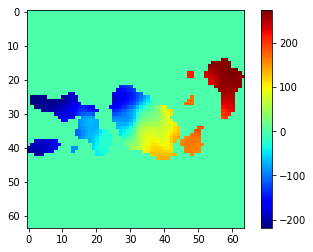

In [16]:
test.info()
print('TRUE LABEL=',test[0].header['LABEL'])
d = test[1].data[100]
d[d != d] = 0
plt.figure()
plt.imshow(d,cmap='jet')
plt.colorbar()
plt.show()

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0], [1])])
data = transform(d.reshape(*d.shape, 1)).unsqueeze(0).float().cuda()
print(data.shape)
output = torch.nn.functional.softmax(model(data),dim=1).cpu().detach().numpy()
print(output)
print('TEST LABEL= ',np.argmax(output))
test.close()

torch.Size([1, 1, 64, 64])
[[0.10622309 0.1435124  0.05875074 0.0495275  0.06827779 0.03227602
  0.17474921 0.17845923 0.15276037 0.03546367]]
TEST LABEL=  7


TRUE LABEL= 0


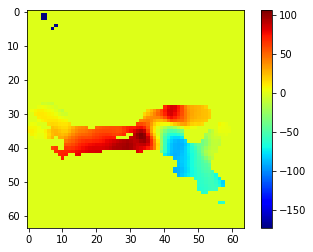

[[0.10622309 0.1435124  0.05875074 0.0495275  0.06827779 0.03227602
  0.17474921 0.17845923 0.15276037 0.03546367]]
7


In [19]:
test2 = fits.open("E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0100N1504,28,1222,0,9017403.fits")
print('TRUE LABEL=',test2[0].header['LABEL'])
d = test2[1].data[100]
d[d != d] = 0
plt.figure()
plt.imshow(d,cmap='jet')
plt.colorbar()
plt.show()
data = torch.from_numpy(d).unsqueeze(0).unsqueeze(0).float().cuda()
output = torch.nn.functional.softmax(model(data),dim=1).cpu().detach().numpy()
print(output)
print(np.argmax(output))